# Interactive PID Control Tuning with  Ziegler-Nichols

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

### Summary

This notebook demonstrates methods for tuning PID controllers using Ziegler-Nichols and other tuning rules.

### Table of Contents

1. [Block Diagram of the Closed-Loop Control System](#blockdiagram)
    * Process Transfer Functions
    * Pade Approximate for Measurement Transfer Function with Time Delay
    * Proportional-Integral Control Transfer Function
2. [Closed-Loop Transfer Functions](#closedloop)
    * Definitions
    * Interactive Simulation
3. [Control Tuning Procedures](#tuning)
    * Ziegler-Nichols
    * Tyreus-Luyben
4. [Exercises](#exercises)
5. [References](#references)
    
### Notebook Initialization

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control.matlab as control

<a id="blockdiagram"></a>
## 1. Block Diagram of the Closed-Loop Control System

The task is to design and tune a PID controller for the closed-loop block shown in the figure below with signal descriptions given in the following table:

| Signal | Description |
| :----: | :---------- |
| $u$    | command to manipulated variable |
| $d$    | disturbance variable input |
| $y$    | controlled varable process output |
| $r$    | controlled variable setpoint |

Transfer functions corresponding to the valve dynamics $G_v(s)$, the process transfer function $G_p(s)$, the disturbance transfer function $G_d(s)$ and measurement transfer function $G_m(s)$ are specified in subsequent cells.

<img src="../images/controlloop.png"/>

### Process Transfer Functions

Valve dynamics:
$$G_v(s) = \frac{1}{2s + 1}$$

Process dynamics:
$$G_p(s) = \frac{1}{5s + 1}$$

Disturbance dynamics:
$$G_d(s) = \frac{1}{5s + 1}$$


In [2]:
Gv = control.tf([1],[2,1])
Gp = control.tf([1],[5,1])
Gd = control.tf([1],[5,1])
print(Gv,Gp,Gd)


   1
-------
2 s + 1
 
   1
-------
5 s + 1
 
   1
-------
5 s + 1



### Measurement Transfer Function

The measurement consists of a pure time delay of 1 minute modeled by the transfer function 

$$G_m(s) = e^{-\tau_d s}$$

where $\tau_d = 1$. The python control library does not currently incorporate time delays modeled by exponentials, therefore an approximation is necessary. The first order Pade approximation is given by

$$e^{-\tau_d s} \approx \frac{-\frac{\tau_d}{2}s + 1}{\frac{\tau_d}{2}s + 1}$$

This is implemented in the python control library by the function `pade(tdelay,norder)` where `tdelay` is the length of the time delay, and `norder` is the order of approximation.

In [3]:
tdelay = 1
norder = 1
num,den = control.pade(tdelay,norder)
Gm = control.tf(num,den)
print(Gm)


-s + 2
------
s + 2



### Proportional-Integral (PI) Control

The classical form for PI control is given by 

$$G_c(s) = K_c\left(1 + \frac{1}{\tau_I s}\right)$$

where $K_c$ is the proportional control gain, and $\tau_I$ in the integrator time constant. Note the making $K_c$ very small is equivalent to turning off the controller, while making $\tau_I$ very large is equivalent to turning off just the integrating portion of the controller.

In the transfer function format

$$G_c(s) = K_c\frac{\tau_I s + 1}{\tau_I s + 0}$$

In [4]:
Kc = 1
tauI = 100

Gc = Kc*control.tf([tauI,1],[tauI,0])
print(Gc)


100 s + 1
---------
  100 s



<a id="closedloop"></a>
## 2. Closed-Loop Transfer Functions

### Definitions

The task we're given is to choose the parameters for a P, PI, or PID controller that result in the good system response. How do we determine if the system response is good or not?

The key to this analysis is to consider a set of four responses

| Response | Transfer function | Description |
| :------: | :---------------: | :---------- |
| $r \rightarrow y$ | $H_{yr}$ | output response to a setpoint change (ideally 1) |
| $d \rightarrow y$ | $H_{yd}$ | output response to a disturbance (ideally 0) |
| $r \rightarrow u$ | $H_{ur}$ | manipulated variable response to a setpoint change |
| $d \rightarrow u$ | $H_{ud}$ | manipulated variable resposne to a disturbance |

Only by examining all four of these can you reach a determination of whether the controller does a good job with respect to both setpoint tracking and disturbance rejection, and that it acheives good output control without excessive or unacceptable changes in the manipulated variable.

The notation use $H$ to designate a closed-loop transfer function and subscripts to indicate the particular pairing of system inputs and outputs. The subscripts correspond to the row and column indices in a matrix equation

$$\left[\begin{array}{c} y \\ u \end{array}\right] =
\left[\begin{array}{cc} H_{yr} & H_{yd} \\ H_{ur} & H_{ud} \end{array}\right]
\left[\begin{array}{c} r \\ d \end{array}\right]$$

For the closed-loop block diagram shown above, the closed-loop transfer functions are given by

$$H_{yr} = \frac{G_p G_v G_c}{1 + G_p G_v G_c G_m}$$

$$H_{yd} = \frac{G_d}{1 + G_p G_v G_c G_m}$$

$$H_{ur} = \frac{G_c}{1 + G_c G_m G_p G_v}$$

$$H_{ud} = -\frac{G_c G_m G_d}{1 + G_c G_m G_p G_v}$$


In [5]:
Hyr = Gp*Gv*Gc/(1+Gp*Gv*Gc*Gm)
Hyd = Gd/(1+Gp*Gv*Gc*Gm)
Hur = Gc/(1+Gc*Gm*Gp*Gv)
Hud = -Gc*Gm*Gd/(1+Gc*Gm*Gp*Gv)

### Interactive Simulation

In [16]:
def sim(Kc = 1, tauI = 1000):
    Gc =  Kc*control.tf([tauI,1],[tauI,0])
    
    Hyr = Gp*Gv*Gc/(1+Gp*Gv*Gc*Gm)
    Hyd = Gd/(1+Gp*Gv*Gc*Gm)
    Hur = Gc/(1+Gc*Gm*Gp*Gv)
    Hud = -Gc*Gm*Gd/(1+Gc*Gm*Gp*Gv)

    t = np.linspace(0,25,1000)

    plt.figure(figsize=(12,6))

    plt.subplot(2,2,1)
    y,t = control.step(Hyr,t)
    plt.plot(t,y)
    plt.ylim(-0.5,2.2)
    plt.title('output response due to step setpoint')
    plt.ylabel('y')

    plt.subplot(2,2,2)
    y,t = control.step(Hyd,t)
    plt.plot(t,y)
    plt.ylim(-0.5,2.2)
    plt.title('output response due to a step disturbance')
    plt.ylabel('y')

    plt.subplot(2,2,3)
    u,t = control.step(Hur,t)
    plt.plot(t,u)
    plt.ylim(-1.5,1.5)
    plt.title('manipulated variable response due to step setpoint')
    plt.ylabel('u')

    plt.subplot(2,2,4)
    u,t = control.step(Hud,t)
    plt.plot(t,u)
    plt.ylim(-1.5,1.5)
    plt.title('manipulated variable response due to a step disturbance')
    plt.ylabel('u')

    plt.tight_layout()

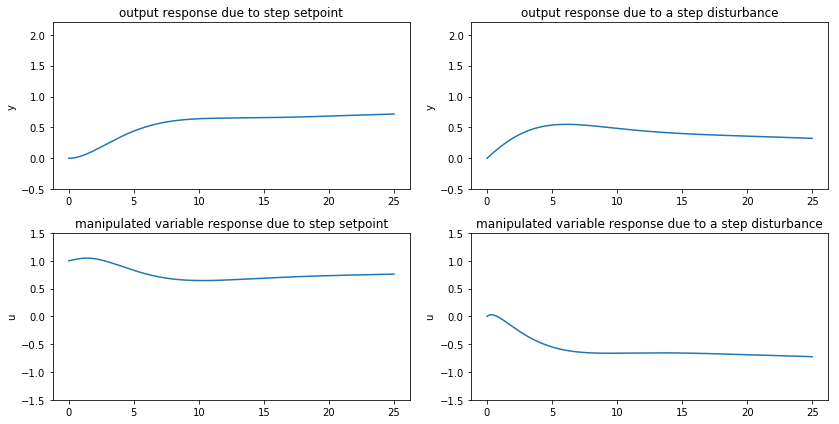

In [17]:
from ipywidgets import interact, fixed
interact(sim,Kc = (0.1,10,0.1),tauI=(0.1,25,1));

<a id="tuning"></a>
## 3. Control Tuning Procedures

Tuning rules are a frequently used method for selecting the parameters for Proportional, Proportional-Integral, and Proportional-Integral-Derivative control. The procedures for the Ziegler-Nichols and Tyreus-Luyben tuning rules are as follows:

1. Begin with the controller turned on in proportional only mode.  This can be acheived by setting $\tau_D = 0$ and $\tau_I$ to the maximum possible value.

2. Increase the proportional gain $K_c$ until you observe continuous cycling in response to a disturbance or setpoint adjustment.  Continous cycling is the boundary between stable and unstable process response. The cycling should have constant amplitude that is neither increasing or descreasing in time. The value of $K_c$ at which you observe continuous cycling is the **ulitmate gain** $K_{cu}$.  The period of the corresponding oscillation is $P_u$ and called the **ultimate period**.

3. Having obtained values for $K_{cu}$ and $P_u$, select the type of control to use, and set parameters usign either the Ziegler-Nichols (agressive, tends to be underdamped) or Tyreus-Luyben (tends to be more appropriate for large scale chemcial processes).

4. Test the closed-loop controlled system response to typical process disturbances and setpoint adjustments. Retune as necessary.

To demonstrate, we used the interactive simulation to determine the ultimate gain and period. The ultimate gain $K_{cu} = 8.1$ and $P_u = 8$.

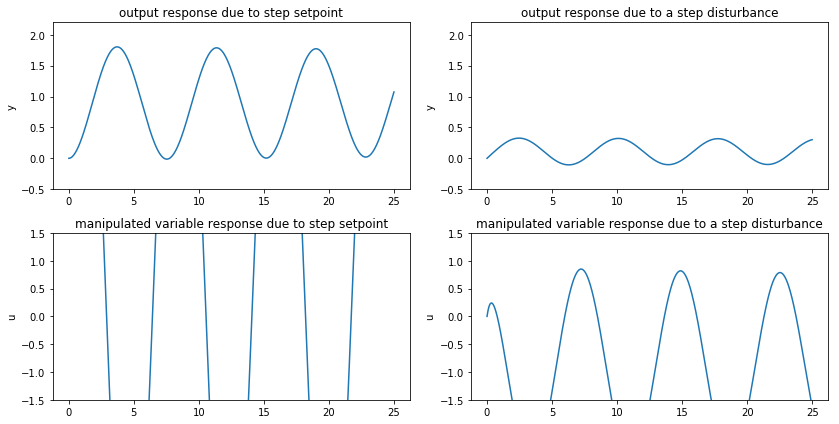

In [18]:
from ipywidgets import fixed
interact(sim,Kc = fixed(8.1), tauI=fixed(1000));

### Ziegler-Nichols

One of the best known set of tuning rules was developed by J. G. Ziegler and N. B. Nichols in 1942 when they working for the Taylor Instrument Company in Rochester, NY.  The rules are summarized as

| Control | $K_c$         | $\tau_I$          | $\tau_D$        |
| :-----: | :-----------: | :---------------: | :-------------: |
| P       | $0.5 K_{cu}$  | -                 | -               |
| PI      | $0.45 K_{cu}$ | $\frac{P_u}{1.2}$ | -               |
| PID     | $0.6 K_{cu}$  | $\frac{P_u}{2}$   | $\frac{P_u}{8}$ |

For the given example, assuming PI control,

$$K_c = 0.45 K_{cu} = 0.45 \times 8.1 = 3.6$$

$$\tau_I = P_u/1.2 = 8/1.2 = 6.7$$

These rules will typically yield a decay ratio of about 25%, which is generally a bit too aggressive for most large scale chemical process applications.


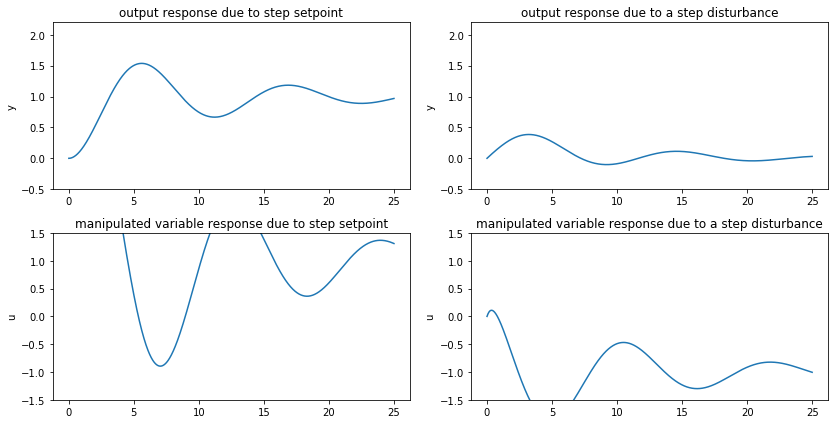

In [19]:
interact(sim,Kc = fixed(3.6), tauI=fixed(6.7));

### Tyreus-Luyben

The Ziegler-Nichols tuning rules are generally regarded as too aggressive for most process control applications. In 1992, based on collaborative research between the Dow Chemical Company and Lehigh University, Bjorn Tyreus and William Luyben proposed the following modification for the traditional tuning rules.

| Control | $K_c$         | $\tau_I$     | $\tau_D$          |
| :-----: | :-----------: | :----------: | :---------------: |
| PI      | $0.31 K_{cu}$ | $2.2 P_u$    | -                 |
| PID     | $0.45 K_{cu}$  | $2.2 P_u$   | $\frac{P_u}{6.3}$ |

For the given example, assuming PI control,

$$K_c = 0.31 K_{cu} = 0.31 \times 8.1 = 2.5$$

$$\tau_I = 2.2 P_u = 2.2 \times 8 = 17.6$$

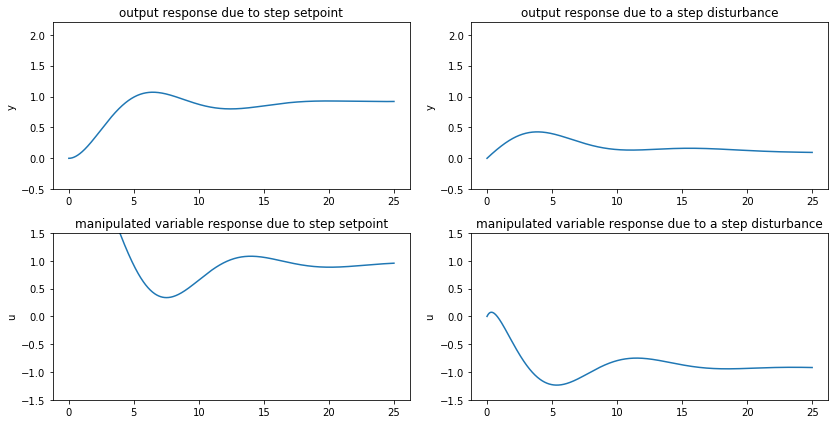

In [20]:
from ipywidgets import fixed
interact(sim,Kc = fixed(2.5), tauI=fixed(17.6));

<a id="exercises"></a>
## 4. Exercises

### Exercise: PID Control

Modify the simulation to include a three parameter PID control of the form

$$G_c(s) = K_c\left(1 + \frac{1}{\tau_Is} + \frac{\tau_Ds}{\frac{\tau_D}{N} s + 1}\right)$$

where $N = 10$. This formulation is needed to avoid a transfer function with a numerator polynomial that is higher order than the denominator polynomial as required by the Python Control Library.

### Exercise: Alternative Tuning Rules

There are wide variety of recommended tuning rules, including several mentioned on the [Wikipedia page describing the Ziegler-Nichols method](https://en.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method). Test these to see if they perform as expected. Can you draw any general conclusions about the superiority of one method to another?

<a id="references"></a>
## References

1. Tyreus, Bjorn D., and William L. Luyben. "Tuning PI controllers for integrator/dead time processes." Industrial & Engineering Chemistry Research 31.11 (1992): 2625-2628.

2. Ziegler, John G., and Nathaniel B. Nichols. "Optimum settings for automatic controllers." trans. ASME 64.11 (1942).